In [1]:
import os
print(os.getcwd())
print(os.listdir())


C:\Users\HP\OneDrive - State Bank of India\Desktop\radio-anomaly-frgadb
['.ipynb_checkpoints', 'data', 'notebook', 'Untitled.ipynb']


In [2]:
print(os.listdir("data"))
print(os.listdir("data/FRI"))


['FRI', 'FRII', 'RRG', 'XRG']
['catalogue.csv', 'FRI_1.fits', 'FRI_10.fits', 'FRI_100.fits', 'FRI_101.fits', 'FRI_102.fits', 'FRI_103.fits', 'FRI_104.fits', 'FRI_105.fits', 'FRI_106.fits', 'FRI_107.fits', 'FRI_108.fits', 'FRI_109.fits', 'FRI_11.fits', 'FRI_110.fits', 'FRI_111.fits', 'FRI_112.fits', 'FRI_113.fits', 'FRI_114.fits', 'FRI_115.fits', 'FRI_116.fits', 'FRI_117.fits', 'FRI_118.fits', 'FRI_119.fits', 'FRI_12.fits', 'FRI_120.fits', 'FRI_121.fits', 'FRI_122.fits', 'FRI_123.fits', 'FRI_124.fits', 'FRI_125.fits', 'FRI_126.fits', 'FRI_127.fits', 'FRI_128.fits', 'FRI_129.fits', 'FRI_13.fits', 'FRI_130.fits', 'FRI_131.fits', 'FRI_132.fits', 'FRI_133.fits', 'FRI_134.fits', 'FRI_135.fits', 'FRI_136.fits', 'FRI_137.fits', 'FRI_138.fits', 'FRI_139.fits', 'FRI_14.fits', 'FRI_140.fits', 'FRI_141.fits', 'FRI_142.fits', 'FRI_143.fits', 'FRI_144.fits', 'FRI_145.fits', 'FRI_146.fits', 'FRI_147.fits', 'FRI_148.fits', 'FRI_149.fits', 'FRI_15.fits', 'FRI_150.fits', 'FRI_151.fits', 'FRI_152.fits', 

In [3]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import os


In [4]:
fits_file = "data/FRI/FRI_1.fits"

hdul = fits.open(fits_file)
image = hdul[0].data
hdul.close()

print("Image shape:", image.shape)
print("Data type:", image.dtype)


Image shape: (300, 300)
Data type: >f4


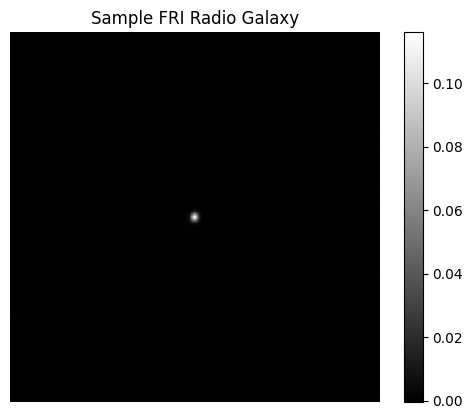

In [5]:
plt.imshow(image, cmap="gray")
plt.colorbar()
plt.title("Sample FRI Radio Galaxy")
plt.axis("off")
plt.show()


Min: 0.0
Max: 1.0


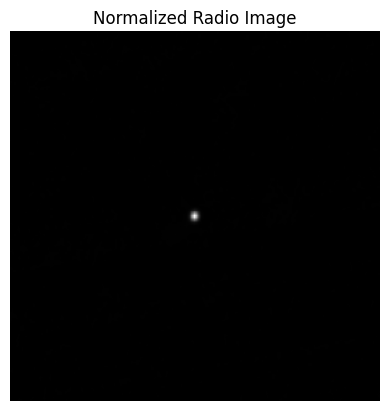

In [6]:
# remove NaNs (important for radio data)
image_clean = np.nan_to_num(image)

# min-max normalization to [0, 1]
image_norm = (image_clean - image_clean.min()) / (image_clean.max() - image_clean.min())

print("Min:", image_norm.min())
print("Max:", image_norm.max())

plt.imshow(image_norm, cmap="gray")
plt.title("Normalized Radio Image")
plt.axis("off")
plt.show()


In [7]:
def load_fits_images(folder_path, resize_shape=(128, 128)):
    images = []
    
    for file in os.listdir(folder_path):
        if file.endswith(".fits"):
            hdul = fits.open(os.path.join(folder_path, file))
            img = hdul[0].data
            hdul.close()
            
            # clean NaNs
            img = np.nan_to_num(img)
            
            # normalize
            img = (img - img.min()) / (img.max() - img.min())
            
            # resize
            img = cv2.resize(img, resize_shape)
            
            images.append(img)
    
    images = np.array(images)
    images = np.expand_dims(images, axis=-1)  # for CNN
    
    return images


In [8]:
import cv2

fri_images = load_fits_images("data/FRI")
frii_images = load_fits_images("data/FRII")

X_normal = np.concatenate([fri_images, frii_images], axis=0)

print("Normal images shape:", X_normal.shape)


Normal images shape: (734, 128, 128, 1)


In [9]:
rrg_images = load_fits_images("data/RRG")
xrg_images = load_fits_images("data/XRG")

X_anomaly = np.concatenate([rrg_images, xrg_images], axis=0)

print("Anomaly images shape:", X_anomaly.shape)


Anomaly images shape: (69, 128, 128, 1)


In [10]:
from sklearn.model_selection import train_test_split

X_train, X_val = train_test_split(
    X_normal,
    test_size=0.2,
    random_state=42
)

print("Train:", X_train.shape)
print("Validation:", X_val.shape)


Train: (587, 128, 128, 1)
Validation: (147, 128, 128, 1)


In [11]:
!pip install tensorflow


In [12]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model

input_img = Input(shape=(128, 128, 1))

# Encoder
x = Conv2D(32, 3, activation='relu', padding='same')(input_img)
x = MaxPooling2D(2, padding='same')(x)
x = Conv2D(64, 3, activation='relu', padding='same')(x)
x = MaxPooling2D(2, padding='same')(x)

# Decoder
x = Conv2D(64, 3, activation='relu', padding='same')(x)
x = UpSampling2D(2)(x)
x = Conv2D(32, 3, activation='relu', padding='same')(x)
x = UpSampling2D(2)(x)

decoded = Conv2D(1, 3, activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 128, 128, 1)         │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 74,497 (291.00 KB)

 Trainable params: 74,497 (291.00 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
history = autoencoder.fit(
    X_train, X_train,
    epochs=30,
    batch_size=16,
    validation_data=(X_val, X_val)
)


Epoch 1/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 178ms/step - loss: 0.0427 - val_loss: 0.0053
Epoch 2/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 170ms/step - loss: 0.0046 - val_loss: 0.0053
Epoch 3/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 174ms/step - loss: 0.0046 - val_loss: 0.0053
Epoch 4/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 169ms/step - loss: 0.0046 - val_loss: 0.0053
Epoch 5/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 173ms/step - loss: 0.0046 - val_loss: 0.0053
Epoch 6/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 170ms/step - loss: 0.0046 - val_loss: 0.0053
Epoch 7/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 167ms/step - loss: 0.0046 - val_loss: 0.0053
Epoch 8/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 167ms/step - loss: 0.0046 - val_loss: 0.0053
Epoch 9/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 167ms/step - loss: 0.0046 - val_loss: 0.0053
Epoch 10/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 170ms/step - loss: 0.0046 - val_loss: 0.0053
Epoch 11/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 168ms/step - loss: 0.0046 - val_loss: 0.0053
Epoch 12/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 168ms/st

In [14]:
def reconstruction_error(model, images):
    recon = model.predict(images)
    error = np.mean((images - recon) ** 2, axis=(1,2,3))
    return error


In [15]:
normal_errors = reconstruction_error(autoencoder, X_normal)
anomaly_errors = reconstruction_error(autoencoder, X_anomaly)

print("Normal error mean:", normal_errors.mean())
print("Anomaly error mean:", anomaly_errors.mean())


23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step 
Normal error mean: 0.0047806567
Anomaly error mean: 0.0041267


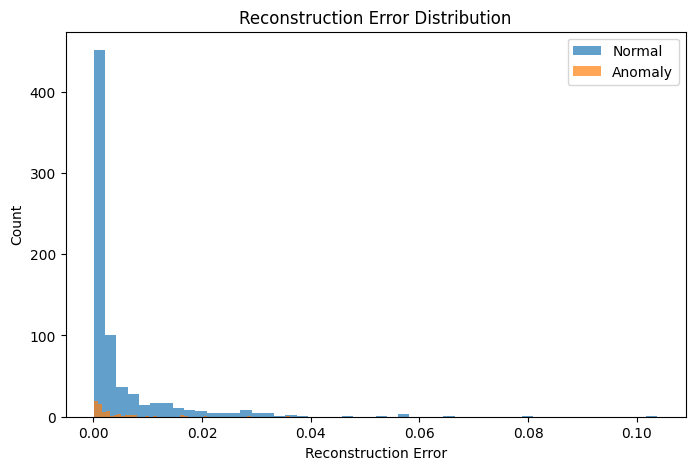

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.hist(normal_errors, bins=50, alpha=0.7, label="Normal")
plt.hist(anomaly_errors, bins=50, alpha=0.7, label="Anomaly")
plt.xlabel("Reconstruction Error")
plt.ylabel("Count")
plt.legend()
plt.title("Reconstruction Error Distribution")
plt.show()


In [17]:
threshold = normal_errors.mean() + 2 * normal_errors.std()
print("Anomaly threshold:", threshold)


Anomaly threshold: 0.023714326


In [18]:
detected_anomalies = anomaly_errors > threshold

print("Detected anomalies:", detected_anomalies.sum())
print("Total anomalies:", len(anomaly_errors))


Detected anomalies: 2
Total anomalies: 69


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


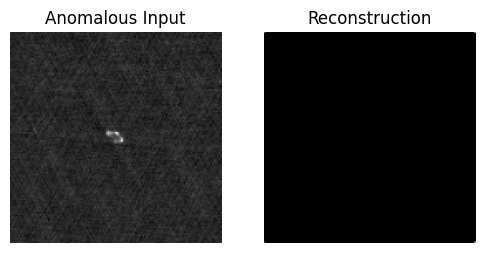

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


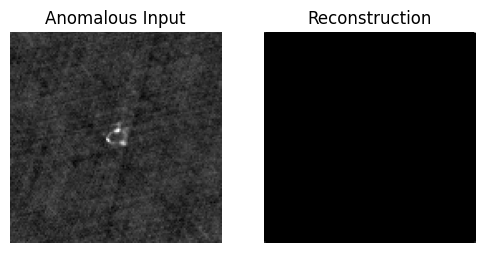

In [19]:
idx = np.where(detected_anomalies)[0]

for i in idx[:5]:
    plt.figure(figsize=(6,3))
    
    plt.subplot(1,2,1)
    plt.imshow(X_anomaly[i].squeeze(), cmap="gray")
    plt.title("Anomalous Input")
    plt.axis("off")
    
    recon = autoencoder.predict(X_anomaly[i:i+1])[0]
    plt.subplot(1,2,2)
    plt.imshow(recon.squeeze(), cmap="gray")
    plt.title("Reconstruction")
    plt.axis("off")
    
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


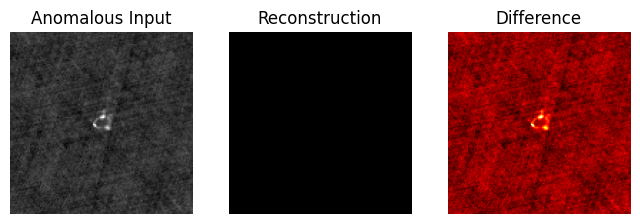

In [20]:
recon = autoencoder.predict(X_anomaly[i:i+1])[0].squeeze()
orig = X_anomaly[i].squeeze()

plt.figure(figsize=(8,3))

plt.subplot(1,3,1)
plt.title("Anomalous Input")
plt.imshow(orig, cmap="gray")
plt.axis("off")

plt.subplot(1,3,2)
plt.title("Reconstruction")
plt.imshow(recon, cmap="gray", vmin=0, vmax=1)
plt.axis("off")

plt.subplot(1,3,3)
plt.title("Difference")
plt.imshow(np.abs(orig - recon), cmap="hot")
plt.axis("off")

plt.show()


In [21]:
X_train, X_val = train_test_split(
    fri_images,
    test_size=0.2,
    random_state=42
)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


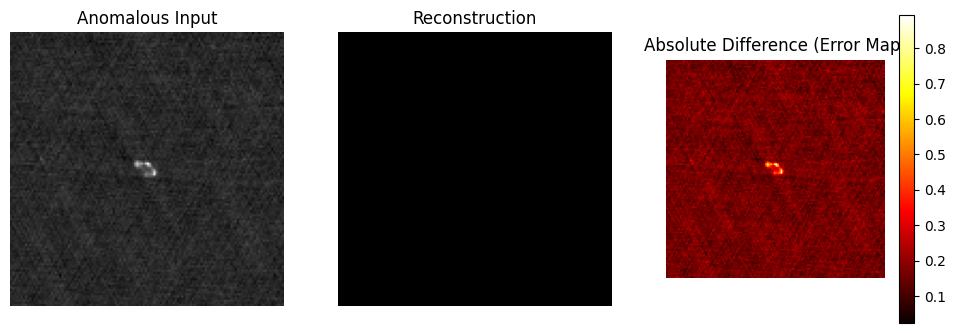

In [22]:
# pick one detected anomaly index (if none, pick any anomaly)
if detected_anomalies.sum() > 0:
    i = np.where(detected_anomalies)[0][0]
else:
    i = 0  # fallback

orig = X_anomaly[i].squeeze()
recon = autoencoder.predict(X_anomaly[i:i+1])[0].squeeze()
diff = np.abs(orig - recon)

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.title("Anomalous Input")
plt.imshow(orig, cmap="gray")
plt.axis("off")

plt.subplot(1,3,2)
plt.title("Reconstruction")
plt.imshow(recon, cmap="gray", vmin=0, vmax=1)
plt.axis("off")

plt.subplot(1,3,3)
plt.title("Absolute Difference (Error Map)")
plt.imshow(diff, cmap="hot")
plt.colorbar()
plt.axis("off")

plt.show()


In [23]:
threshold_p95 = np.percentile(normal_errors, 95)
print("95th percentile threshold:", threshold_p95)

detected_p95 = anomaly_errors > threshold_p95
print("Detected anomalies (p95):", detected_p95.sum(), "/", len(anomaly_errors))


95th percentile threshold: 0.023589937
Detected anomalies (p95): 2 / 69
